Using TensorFlow backend.


<Figure size 640x480 with 1 Axes>

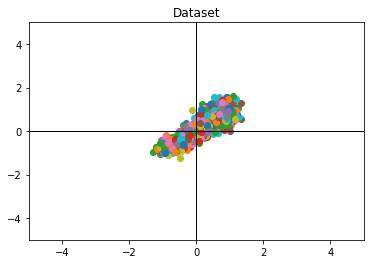

[[5.84117647 5.59411765]
 [3.75882353 4.27058824]
 [5.91764706 5.84705882]
 ...
 [5.40588235 5.72352941]
 [5.23529412 5.77647059]
 [5.20588235 5.22352941]]


In [1]:
import librosa
import matplotlib.pyplot as plt
import librosa.display
import os
import pandas as pandas
from opt_einsum.backends import tensorflow
from sklearn.model_selection import train_test_split
from tensorflow import keras
import tensorflow as tf
import numpy
import csv
    
import warnings
warnings.filterwarnings("ignore")










# Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from keras import models
from keras import layers

def load(file): 
    y , sr = librosa.load(file, mono=True, duration = 10)

    onset_env = librosa.onset.onset_strength(y, sr=sr)
    out = {
        'filename': file,
        'arousal': 0,
        'valence': 0,
        #Mel-based Power Spectrogram
        'melspectrogram': numpy.mean(librosa.feature.melspectrogram(y=y, sr=sr)),
        #Tempo features
        'tempo': numpy.mean(librosa.beat.tempo(onset_envelope=onset_env, sr=sr)),
        'tempo_std': numpy.std(librosa.beat.tempo(onset_envelope=onset_env, sr=sr, aggregate=None)),
        
        # Zero Cross Rating
        'zcr': numpy.mean(librosa.feature.zero_crossing_rate(y)),
        'zcr_std': numpy.std(librosa.feature.zero_crossing_rate(y)),
        
        #Octave contrast std
        'spectral_contrast_std': numpy.std(librosa.feature.spectral_contrast(y=y, sr=sr))
    }
    
    #Extract all Mel-frequency cepstral coefficients 
    counter = 1
    for mfcc in (librosa.feature.mfcc(y=y, sr=sr)):
        out[('mfcc%s' % counter)] = numpy.mean(mfcc)
        counter = counter + 1
            
    #Chromagram of a Short Time Fourier Transform             
    counter = 1
    for chroma_stft in (librosa.feature.chroma_stft(y=y, sr=sr)):
        out[('chroma_stft%s' % counter)] = numpy.mean(chroma_stft)
        counter = counter + 1
    
    #Octave-based Spectral Contrast        
    counter = 1
    for spectral_contrast in (librosa.feature.spectral_contrast(y=y, sr=sr)):
        out[('spectral_contrast%s' % counter)] = numpy.mean(spectral_contrast)
        counter = counter + 1
        
    #Tonnetz        
    counter = 1
    for tonnetz in (librosa.feature.tonnetz(y=y, sr=sr)):
        out[('tonnetz%s' % counter)] = numpy.mean(tonnetz)
        counter = counter + 1
    
    return out

loaded = True
datafile = './data2.json'

import json
import numpy as np
import matplotlib.pyplot as plt

class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, (np.int_, np.intc, np.intp, np.int8,
            np.int16, np.int32, np.int64, np.uint8,
            np.uint16, np.uint32, np.uint64)):
            return int(obj)
        elif isinstance(obj, (np.float_, np.float16, np.float32, 
            np.float64)):
            return float(obj)
        elif isinstance(obj,(np.ndarray,)): #### This is the fix
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

def base():
    plt.figure()
    # Set x-axis range
    plt.xlim((-5,5))
    # Set y-axis range
    plt.ylim((-5,5))
    # Draw lines to split quadrants
    plt.plot([0,0],[-5,5], linewidth=1, color='black')
    plt.plot([5,-5],[0,0], linewidth=1, color='black')
    plt.title("Dataset")
    
    return plt
    
def scatter(plt, arousal, valence):
    #Normalize input
    arousal = arousal
    valence = valence
    
    plt.scatter(arousal, valence)

def toEmotionIn(arousal, valence, song):    
    
    plt.figure()
    # Set x-axis range
    plt.xlim((-5,5))
    # Set y-axis range
    plt.ylim((-5,5))
    # Draw lines to split quadrants
    plt.plot([0,0],[-5,5], linewidth=1, color='black')
    plt.plot([5,-5],[0,0], linewidth=1, color='black')
    plt.scatter(valence, arousal)
    plt.title("Inverted: %s" % song)
    plt.show()

def toEmotion(arousal, valence, song):
    #Normalize input
    arousal = arousal -5;
    valence = valence -5;
    
    plt.figure()
    # Set x-axis range
    plt.xlim((-5,5))
    # Set y-axis range
    plt.ylim((-5,5))
    # Draw lines to split quadrants
    plt.plot([0,0],[-5,5], linewidth=1, color='black')
    plt.plot([5,-5],[0,0], linewidth=1, color='black')
    plt.scatter(arousal, valence)
    plt.title(song)
    plt.show()
    toEmotionIn(arousal, valence, song)
        
if not loaded:
    tracks = []
    basedir = './MEMD_audio'
    annotations = {'arousal': {}, 'valence': {}}

    def annotation(file):
        with open(file) as fh:
            rd = csv.DictReader(fh, delimiter=',')
            for row in rd:
                annotations['arousal']["%s.mp3" % row['song_id']] = row[' arousal_mean']
                annotations['valence']["%s.mp3" % row['song_id']] = row[' valence_mean']
            
    annotation('./annotations1.csv')
    annotation('./annotations2.csv')
    
    print(annotations)
    
    for track in os.listdir(basedir):   
        if len(tracks) < 2500:
            print(len(tracks))
            track_data = load(basedir + '/' + track)
            track_data['arousal'] = annotations['arousal'][track]
            track_data['valence'] = annotations['valence'][track]
            tracks.append(track_data)
    
    with open(datafile, 'w') as file_out:
        json.dump(tracks , file_out, cls=NumpyEncoder)
else:
    data = pandas.read_json(datafile)
    data = data.drop(['filename'],axis=1)
    
    x = data.iloc[:, 2:]   
    y = data.iloc[:, :2]
    
    scalerX = StandardScaler()
    scalerY = StandardScaler()  
    x = scalerX.fit_transform(numpy.array(x, dtype = float))
    y = scalerY.fit_transform(numpy.array(y, dtype = float))
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)
    
    p = base()
    for sub in y_train:
        scatter(p, sub[0], sub[1])
    
    p.show()
    
    #import required packages
    from sklearn import neighbors
    from sklearn.metrics import mean_squared_error 
    from math import sqrt
    import matplotlib.pyplot as plt
    %matplotlib inline
    from sklearn.model_selection import GridSearchCV

    
    # rmse_val = [] #to store rmse values for different k
    # for K in range(20):
    #     K = K+1
    #     model = neighbors.KNeighborsRegressor(n_neighbors = K)
    # 
    #     model.fit(x_train, y_train)  #fit the model
    #     pred=model.predict(x_test) #make prediction on test set
    #     error = sqrt(mean_squared_error(y_test,pred)) #calculate rmse
    #     rmse_val.append(error) #store rmse values
    #     print('RMSE value for k= ' , K , 'is:', error)
    # 
    # #plotting the rmse values against k values
    # curve = pandas.DataFrame(rmse_val) #elbow curve 
    # curve.plot()
    # 
    # params = {'n_neighbors':[]}
    # for i in range(2, 20):
    #     params['n_neighbors'].append(i)
    #    
    #     
    # knn = neighbors.KNeighborsRegressor()
    # model = GridSearchCV(knn, params, cv=5)
    # model.fit(x_train,y_train)
    # print(model.best_params_)
    # 
    model = neighbors.KNeighborsRegressor(n_neighbors = 17)
    model.fit(x_train, y_train) 

    predict = model.predict(x_train)

    p = base()
    for sub in predict:
        scatter(p, sub[0], sub[1])
    
    p.show()
    
   
    print(scalerY.inverse_transform(predict))